<a href="https://colab.research.google.com/github/MarrinXia/MSSP-607/blob/main/AdventureWorks_InternetSales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adventure Works Internet Sales — Case Study Assignment 2

This notebook:
1. Loads the Internet Sales data
2. Cleans and prepares key fields
3. Answers required questions with tables and plots
4. Saves outputs for report


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

# Read the CSV file from Google Drive
df = pd.read_csv('/content/drive/MyDrive/InternetSales.csv', encoding='cp1252')

# Display basic information
print("="*60)
print("Dataset Successfully Loaded!")
print("="*60)
print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print()
print("Column names:")
print(df.columns.tolist())
print()
print("First few rows:")
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Successfully Loaded!
Dataset shape: (60398, 60)
Rows: 60,398
Columns: 60

Column names:
['ID', 'CustomerKey', 'GeographyKey', 'City', 'CountryRegionCode', 'EnglishCountryRegionName', 'CustomerAlternateKey', 'Title', 'FirstName', 'MiddleName', 'LastName', 'NameStyle', 'BirthDate', 'MaritalStatus', 'Suffix', 'Gender', 'EmailAddress', 'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome', 'EnglishEducation', 'SpanishEducation', 'FrenchEducation', 'EnglishOccupation', 'SpanishOccupation', 'FrenchOccupation', 'HouseOwnerFlag', 'NumberCarsOwned', 'AddressLine1', 'AddressLine2', 'Phone', 'DateFirstPurchase', 'CommuteDistance', 'ProductKey', 'EnglishProductName', 'OrderDateKey', 'DueDateKey', 'ShipDateKey', 'CustomerKey.1', 'PromotionKey', 'CurrencyKey', 'SalesTerritoryKey', 'SalesOrderNumber', 'SalesOrderLineNumber', 'RevisionNumber', 'OrderQuantity', 'Uni

/tmp/ipython-input-1668191227.py:12: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/InternetSales.csv', encoding='cp1252')


,ID,CustomerKey,GeographyKey,City,CountryRegionCode,EnglishCountryRegionName,CustomerAlternateKey,Title,FirstName,MiddleName,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,0,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,NaN,NaN,1/19/2011,1/31/2011,1/26/2011
1,1,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,1265.6195,1265.6195,2319.99,185.5992,57.9998,NaN,NaN,1/18/2013,1/30/2013,1/25/2013
2,2,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,8.2205,8.2205,21.98,1.7584,0.5495,NaN,NaN,1/18/2013,1/30/2013,1/25/2013
3,3,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,1481.9379,1481.9379,2384.07,190.7256,59.6018,NaN,NaN,5/3/2013,5/15/2013,5/10/2013
4,4,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,10.8423,10.8423,28.99,2.3192,0.7248,NaN,NaN,5/3/2013,5/15/2013,5/10/2013


In [ ]:
import re
def find_col(df, candidates):
    cols_norm = {c: re.sub(r"[^a-z0-9]+", "", c.lower()) for c in df.columns}
    for c, norm in cols_norm.items():
        for key in candidates:
            if key in norm:
                return c
    return None

col_country = find_col(df, ["countryregion", "country", "region"])
col_orderdate = find_col(df, ["orderdate", "date"])
col_year = find_col(df, ["orderyear", "fiscalyear", "year"])
col_sales = find_col(df, ["salesamount", "salestotal", "linetotal", "revenue", "amount", "sales"])
col_category = find_col(df, ["productcategory", "category", "productline", "subcategory"])
col_unit_price = find_col(df, ["unitprice", "listprice", "price"])
col_qty = find_col(df, ["orderquantity", "orderqty", "quantity", "qty"])
col_gender = find_col(df, ["gender", "sex"])
col_income = find_col(df, ["yearlyincome", "annualincome", "income"])
col_homeowner = find_col(df, ["houseownerflag", "homeownerflag", "homeowner", "houseowner", "isowner"])

# Derive year
if col_year is None and col_orderdate is not None:
    df['_parsed_date'] = pd.to_datetime(df[col_orderdate], errors='coerce', infer_datetime_format=True)
    df['_Year'] = df['_parsed_date'].dt.year
    used_year = '_Year'
else:
    used_year = col_year

# Sales fallback
if col_sales is None and col_unit_price is not None and col_qty is not None:
    df['_SalesAmount'] = pd.to_numeric(df[col_unit_price], errors='coerce') * pd.to_numeric(df[col_qty], errors='coerce')
    col_sales = '_SalesAmount'

if col_category is None:
    df['ProductCategory'] = 'Unknown'
    col_category = 'ProductCategory'
if col_country is None:
    df['CountryRegion'] = 'Unknown'
    col_country = 'CountryRegion'

if used_year is None:
    raise ValueError('Could not determine Year. Ensure your data has a Year or OrderDate column.')

df[col_sales] = pd.to_numeric(df[col_sales], errors='coerce')
if col_income is not None:
    df[col_income] = pd.to_numeric(df[col_income], errors='coerce')

def to_bool_series(s):
    s = s.astype(str).str.strip().str.lower()
    return s.map({'y': True, 'yes': True, 'true': True, '1': True, 'n': False, 'no': False, 'false': False, '0': False})

if col_homeowner is not None:
    df['_Homeowner'] = to_bool_series(df[col_homeowner])
else:
    df['_Homeowner'] = np.nan

print('Detected columns:', {
    'Year': used_year, 'CountryRegion': col_country, 'Sales': col_sales,
    'Category': col_category, 'UnitPrice': col_unit_price, 'Quantity': col_qty,
    'Gender': col_gender, 'Income': col_income, 'Homeowner': col_homeowner
})

Detected columns: {'Year': 'YearlyIncome', 'CountryRegion': 'CountryRegionCode', 'Sales': 'SalesTerritoryKey', 'Category': 'ProductCategory', 'UnitPrice': 'UnitPrice', 'Quantity': 'OrderQuantity', 'Gender': 'Gender', 'Income': 'YearlyIncome', 'Homeowner': 'HouseOwnerFlag'}


In [ ]:
# Q1: Internet sales by Year for each Country/Region
sales_by_year_country = (
    df.groupby([used_year, col_country], dropna=False)[col_sales]
      .sum()
      .reset_index()
      .rename(columns={used_year: 'Year', col_country: 'CountryRegion', col_sales: 'InternetSales'})
      .sort_values(['Year', 'CountryRegion'])
)
sales_by_year_country.head()

,Year,CountryRegion,InternetSales
0,10000,AU,8937
1,10000,CA,36
2,10000,DE,5184
3,10000,FR,6538
4,10000,GB,7460


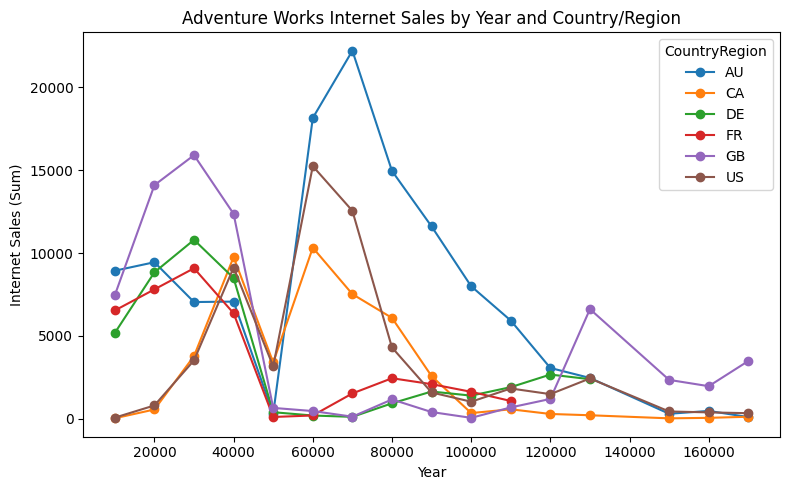

In [ ]:
# Plot: Sales by Year x Country/Region
piv = sales_by_year_country.pivot(index='Year', columns='CountryRegion', values='InternetSales')
plt.figure(figsize=(8,5))
piv.plot(ax=plt.gca(), marker='o')
plt.title('Adventure Works Internet Sales by Year and Country/Region')
plt.xlabel('Year')
plt.ylabel('Internet Sales (Sum)')
plt.tight_layout()
plt.show()

In [ ]:
# Q2: Summary stats for Yearly Income by CountryRegion & Gender
if (col_income is not None) and (col_gender is not None):
    income_stats = (
        df.groupby([col_country, col_gender])[col_income]
        .agg(['count', 'min', 'max', 'mean', 'std'])
        .reset_index()
        .rename(columns={col_country: 'CountryRegion', col_gender: 'Gender',
                         'count': 'N', 'min':'MinIncome', 'max':'MaxIncome',
                         'mean':'MeanIncome','std':'StdIncome'})
    )
    income_stats.head()
else:
    print('Income and/or Gender columns not found; skip Q2.')

In [ ]:
# Q3: Average price of the product category with most sales
top = df.groupby(col_category, dropna=False)[col_sales].sum().sort_values(ascending=False).head(1)
top_cat = top.index[0]
top_sales = top.iloc[0]
avg_price = None
method_used = None
if col_unit_price is not None:
    avg_price = pd.to_numeric(df.loc[df[col_category]==top_cat, col_unit_price], errors='coerce').mean()
    method_used = f'Mean of {col_unit_price}'
elif (col_qty is not None) and (col_sales is not None):
    subset = df.loc[df[col_category]==top_cat].copy()
    denom = pd.to_numeric(subset[col_qty], errors='coerce').sum()
    numer = pd.to_numeric(subset[col_sales], errors='coerce').sum()
    avg_price = numer/denom if denom else np.nan
    method_used = 'Weighted price = sum(Sales)/sum(Quantity)'
else:
    price_like = [c for c in df.columns if re.search(r'price', c, flags=re.I)]
    if price_like:
        avg_price = pd.to_numeric(df.loc[df[col_category]==top_cat, price_like[0]], errors='coerce').mean()
        method_used = f'Mean of {price_like[0]}'

print({'TopCategory': top_cat, 'TopCategorySales': float(top_sales), 'AveragePrice': None if pd.isna(avg_price) else float(avg_price), 'Method': method_used})

{'TopCategory': 'Unknown', 'TopCategorySales': 377153.0, 'AveragePrice': 486.0869105053146, 'Method': 'Mean of UnitPrice'}


In [ ]:
# Q4: Homeownership vs Sales
if df['_Homeowner'].notna().any():
    homeowner_summary = (
        df.groupby('_Homeowner')[col_sales]
        .agg(['count','sum','mean','median','std'])
        .reset_index()
        .rename(columns={'_Homeowner':'Homeowner','sum':'TotalSales','mean':'AvgOrderValue'})
    )
    homeowner_summary
else:
    print('Homeowner flag not available; skip Q4.')

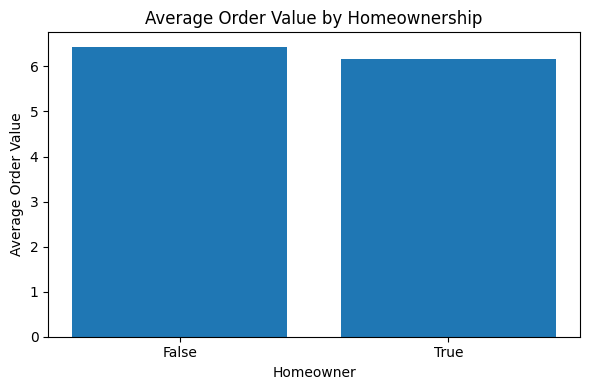

In [ ]:
# Plot: Avg order value by Homeownership
try:
    x = homeowner_summary['Homeowner'].astype(str)
    y = homeowner_summary['AvgOrderValue']
    plt.figure(figsize=(6,4))
    plt.bar(x, y)
    plt.title('Average Order Value by Homeownership')
    plt.xlabel('Homeowner')
    plt.ylabel('Average Order Value')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Could not plot homeownership chart:', e)

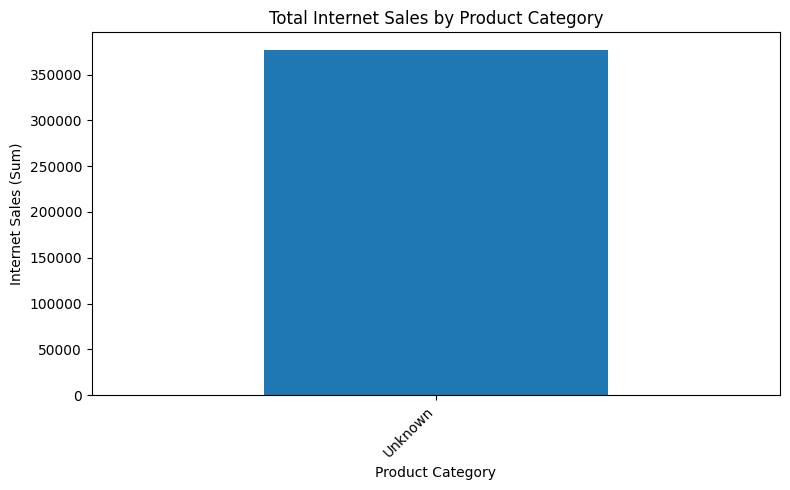

In [ ]:
# Plot: Total sales by Product Category
sales_by_category = df.groupby(col_category, dropna=False)[col_sales].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sales_by_category.plot(kind='bar')
plt.title('Total Internet Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Internet Sales (Sum)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Save outputs for report
os.makedirs('output/figures', exist_ok=True)
sales_by_year_country.to_csv('output/sales_by_year_country.csv', index=False)
try:
    income_stats.to_csv('output/income_stats_by_country_gender.csv', index=False)
except:
    pass
sales_by_category.to_csv('output/sales_by_category.csv')
plt.figure()
sales_by_category.plot(kind='bar')
plt.title('Total Internet Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Internet Sales (Sum)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('output/figures/sales_by_category.png', dpi=180)
plt.close()
print('Saved outputs to output/')

Saved outputs to output/
